<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Analyses](02.00-analyses.ipynb) | [Contents](Index.ipynb) | [Joint reactions](02.02-joint-reactions.ipynb) >

# Muscle activations & muscles forces

In [1]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt
from pyosim import Conf
from pyomeca import Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    parse_conditions,
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
    ridge_plot
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
aws_conf = yaml.safe_load(open("../conf.yml"))

conf = Conf(project_path=aws_conf["path"]["project"]["local"])
conf.check_confs()

Project loaded
Configuration file loaded


## Reading files

In [4]:
suffix = "_StaticOptimization_activation"
# suffix = "_StaticOptimization_force"

act = (
    pd.concat(
        [
            Analogs3d.from_sto(ifile)
            .time_normalization()
            .to_dataframe()
            .assign(filename=ifile.stem)
            for ifile in conf.project_path.glob(f"*/3_static_optimization/*{suffix}*")
        ]
    )
    .pipe(parse_conditions, suffix="wu_", prefix=suffix)
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("mass != 18")
)

act.head()

,index,LVS,TRP1,TRP2,TRP3,TRP4,RMN,RMJ1,RMJ2,SRA1,...,AC3,GH1,GH2,GH3,filename,participant,men,height,mass,n_trial
0,0.00,0.093195,0.194355,0.083498,0.055261,0.045271,0.105586,0.029389,0.010329,0.066250,...,0.008311,-0.026867,0.022399,0.020511,VerCF12H2_3,verc,0,2,12,3
1,0.01,0.129131,0.309957,0.134745,0.094603,0.057375,0.152283,0.032945,0.010123,0.011763,...,0.014365,-0.036946,0.028573,0.033740,VerCF12H2_3,verc,0,2,12,3
2,0.02,0.203825,0.365121,0.189626,0.139795,0.095451,0.228780,0.037695,0.010086,0.010040,...,0.026711,-0.051659,0.038459,0.049153,VerCF12H2_3,verc,0,2,12,3
3,0.03,0.327648,0.479070,0.278189,0.204747,0.171899,0.349120,0.051687,0.010075,0.010031,...,0.044441,-0.076361,0.055289,0.071399,VerCF12H2_3,verc,0,2,12,3
4,0.04,0.396332,0.566834,0.359928,0.260211,0.224858,0.410618,0.050651,0.010039,0.010029,...,0.057666,-0.097264,0.071052,0.086335,VerCF12H2_3,verc,0,2,12,3


## Clean data

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [5]:
to_bold = lambda x: "\033[1m" + x + "\033[0m"

print(to_bold("Initial"))
condition_counter(act)

Initial
n. participants: 37
----------
men
0    110
1    101
----------
height
2    211
----------
mass
6     106
12    105
----------
men  mass
0    6       54
     12      56
1    6       52
     12      49
----------


In [6]:
balanced_trials = random_balanced_design(
    act, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].tolist()
act = act.query("filename == @balanced_trials")

print(to_bold("Balanced:"))
condition_counter(act)

Balanced:
n. participants: 37
----------
men
0    98
1    98
----------
height
2    196
----------
mass
6     98
12    98
----------
men  mass
0    6       49
     12      49
1    6       49
     12      49
----------


### Drop unwanted variables

In [7]:
id_vars = ["filename", "participant", "men", "height", "mass", "n_trial", "index"]
act_melt = act.melt(id_vars=id_vars)
act_melt.head()

,filename,participant,men,height,mass,n_trial,index,variable,value
0,VerCF12H2_3,verc,0,2,12,3,0.00,LVS,0.093195
1,VerCF12H2_3,verc,0,2,12,3,0.01,LVS,0.129131
2,VerCF12H2_3,verc,0,2,12,3,0.02,LVS,0.203825
3,VerCF12H2_3,verc,0,2,12,3,0.03,LVS,0.327648
4,VerCF12H2_3,verc,0,2,12,3,0.04,LVS,0.396332


In [8]:
blacklist = ["AC1", "AC2", "AC3", "SC1", "SC2", "SC3", "GH1", "GH2", "GH3"]
blacklist = blacklist + [
    "box_Rx",
    "box_Ry",
    "box_Rz",
    "box_Tx",
    "box_Ty",
    "box_Tz",
    "thorax_Tx",
    "thorax_Ty",
    "thorax_Tz",
    "thorax_Rx",
    "thorax_Ry",
    "thorax_Rz",
    "elbow_Rz",
    "elbow_Ry",
    "hand_Rz",
    "hand_Rx",
    "hand_r_s2h_Fx",
    "hand_r_s2h_Fy",
    "hand_r_s2h_Fz",
    "hand_r_s2h_Tx",
    "hand_r_s2h_Ty",
    "hand_r_s2h_Tz",
]

act_melt = act_melt.query("variable != @blacklist")

## Description

In [9]:
print(
    f"value > 0.999 = {act_melt.query('value > 0.999').shape[0] / act_melt.shape[0] * 100:.2f}%"
)

value > 0.999 = 5.40%


In [10]:
x = act_melt.groupby(["variable", "index"])["value"].mean().reset_index()
x.head()

,variable,index,value
0,CORB,0.00,0.013195
1,CORB,0.01,0.011520
2,CORB,0.02,0.011491
3,CORB,0.03,0.011129
4,CORB,0.04,0.010922


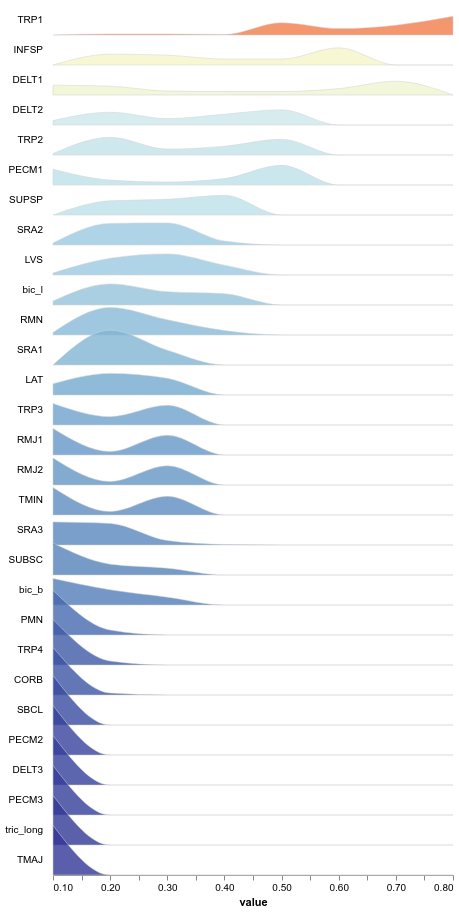

In [20]:
ridge_plot(
    act_melt.groupby(["variable", "index"])["value"].mean().reset_index(),
    value="value",
    groupby="variable",
    sort=act_melt.groupby(["variable"])["value"]
    .mean()
    .sort_values(ascending=False)
    .index.to_list(),
)

## $\sum$activation

In [11]:
sum_act = act_melt.groupby(id_vars)["value"].sum().reset_index()
sum_act.head()

,filename,participant,men,height,mass,n_trial,index,value
0,AimQF12H2_1,aimq,0,2,12,1,0.00,718.819903
1,AimQF12H2_1,aimq,0,2,12,1,0.01,592.425415
2,AimQF12H2_1,aimq,0,2,12,1,0.02,551.365705
3,AimQF12H2_1,aimq,0,2,12,1,0.03,575.656201
4,AimQF12H2_1,aimq,0,2,12,1,0.04,716.593768


In [12]:
y = (
    sum_act.assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index(id_vars)
    .unstack()
)
y.head()

value              \
index                                                  0.00        0.01   
filename    participant men height mass n_trial                           
AimQF12H2_1 0           0   2      12   1        718.819903  592.425415   
AimQF12H2_2 0           0   2      12   2        839.144931  738.331368   
AimQF12H2_3 0           0   2      12   3        509.444649  402.857362   
AimQF6H2_1  0           0   2      6    1        730.850649  733.009993   
AimQF6H2_2  0           0   2      6    2        730.179835  661.904267   

                                                                          \
index                                                  0.02         0.03   
filename    participant men height mass n_trial                            
AimQF12H2_1 0           0   2      12   1        551.365705   575.656201   
AimQF12H2_2 0           0   2      12   2        562.613894   478.044743   
AimQF12H2_3 0           0   2      12   3        396.257602   387.331342   
AimQF6H2_1  0           0   2      6    1        738.391231  1128.778025   
AimQF6H2_2  0           0   2      6    2        621.831948   643.808847   

                                                                           \
index                                                   0.04         0.05   
filename    participant men height mass n_trial                             
AimQF12H2_1 0           0   2      12   1         716.593768   748.841771   
AimQF12H2_2 0           0   2      12   2         437.696157   511.426171   
AimQF12H2_3 0           0   2      12   3         456.696403   407.996200   
AimQF6H2_1  0           0   2      6    1        1340.653493  1365.680268   
AimQF6H2_2  0           0   2      6    2         959.392627  1231.783813   

                                                                           \
index                                                   0.06         0.07   
filename    participant men height mass n_trial                             
AimQF12H2_1 0           0   2      12   1         651.952935   948.688575   
AimQF12H2_2 0           0   2      12   2         598.808090   554.511587   
AimQF12H2_3 0           0   2      12   3         333.087885   281.470057   
AimQF6H2_1  0           0   2      6    1        1397.746729  1413.784133   
AimQF6H2_2  0           0   2      6    2        1362.197672  1523.104246   

                                                                           \
index                                                   0.08         0.09   
filename    participant men height mass n_trial                             
AimQF12H2_1 0           0   2      12   1        1805.003499  1939.895800   
AimQF12H2_2 0           0   2      12   2         998.273150  2110.587204   
AimQF12H2_3 0           0   2      12   3        1592.584634  2383.008040   
AimQF6H2_1  0           0   2      6    1        1376.610371  1359.349069   
AimQF6H2_2  0           0   2      6    2        1534.526081  1440.285875   

                                                 ...               \
index                                            ...         0.91   
filename    participant men height mass n_trial  ...                
AimQF12H2_1 0           0   2      12   1        ...  1937.536834   
AimQF12H2_2 0           0   2      12   2        ...  2624.098335   
AimQF12H2_3 0           0   2      12   3        ...  1368.901314   
AimQF6H2_1  0           0   2      6    1        ...  1497.557256   
AimQF6H2_2  0           0   2      6    2        ...  2093.856748   

                                                                           \
index                                                   0.92         0.93   
filename    participant men height mass n_trial                             
AimQF12H2_1 0           0   2      12   1        1553.026777  1500.813241   
AimQF12H2_2 0           0   2      12   2        2550.580866  2097.428000   
AimQF12H2_3 0           0   2      12   3        1394.2

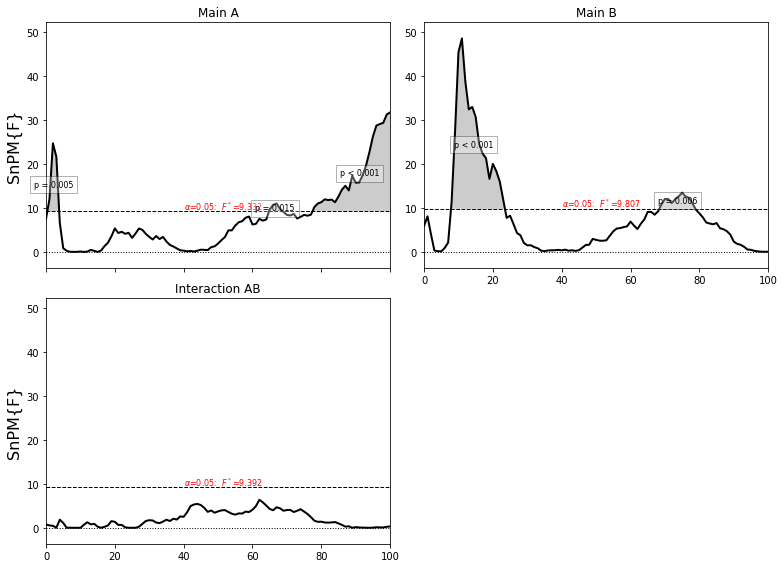

In [13]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [14]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main sex,0.005,0.00396371,0.0378201
1,main sex,0.0146667,0.642026,0.680007
2,main sex,0,0.767136,0.990099
3,main mass,0,0.0775962,0.232731
4,main mass,0.006,0.676819,0.780951


In [15]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [16]:
base = alt.Chart(sum_act).encode(
    alt.X("index", title="normalized trial", axis=alt.Axis(format="%"))
)
mu = base.mark_line().encode(alt.Y("mean(value)", title="Σ activation"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))

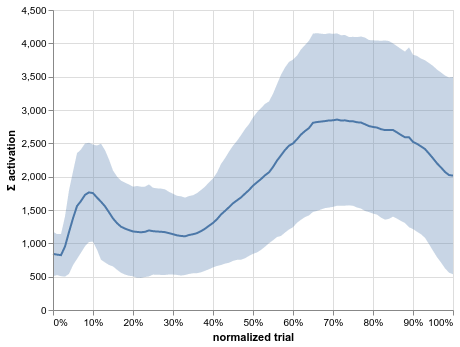

In [17]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

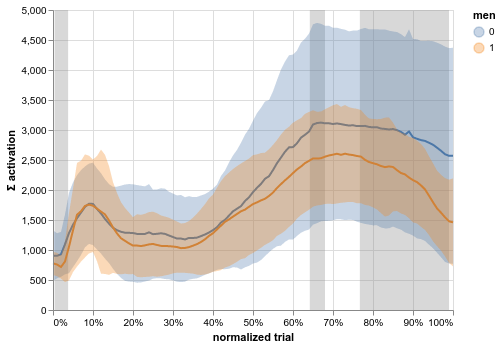

In [18]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N")
)

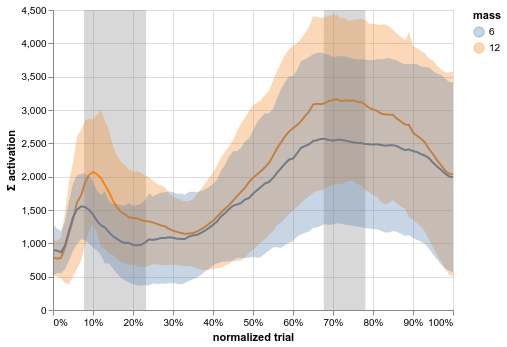

In [19]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

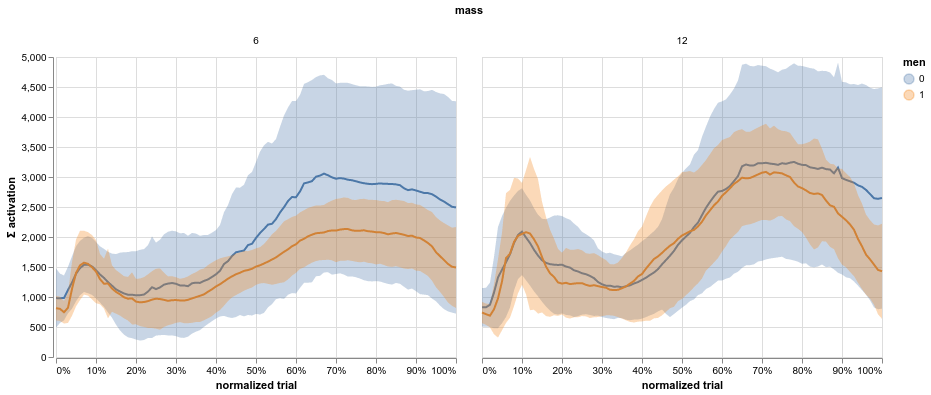

In [20]:
(mu + sigma).encode(alt.Color("men:N")).facet(column="mass")

## ECDF

### ECDF on activations

In [21]:
act_melt["ecdf"] = act_melt.groupby("filename")["value"].transform(
    lambda x: x.rank(method="first") / x.shape[0]
)

In [28]:
target_col_shape = 100

y = (
    act_melt.drop(["index", "variable"], axis=1)
    .assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index([i if i != "index" else "ecdf" for i in id_vars])
    #     .unstack()
)
# y = y.iloc[:, 0 :: int(y.shape[1] / target_col_shape)]
y.head()

value
filename   participant men height mass n_trial ecdf               
VerCF6H2_3 34          0   2      6    3       0.560942  23.652682
                                               0.579379  27.103029
                                               0.574940  25.942840
                                               0.589621  29.718247
                                               0.594059  31.283189

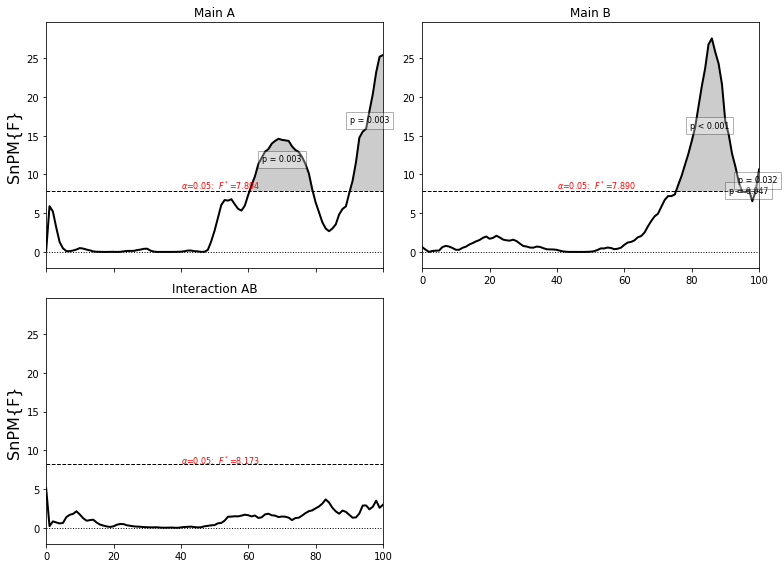

In [26]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [27]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main sex,0.00333333,0.598167,0.783454
1,main sex,0.00333333,0.892889,0.990099
2,main mass,0.000333333,0.746337,0.939758
3,main mass,0.0466667,0.95523,0.961445
4,main mass,0.0316667,0.980377,0.990099


In [28]:
base = alt.Chart(y.stack().reset_index()).encode(
    alt.X("ecdf", axis=alt.Axis(format="%"), title="ecdf")
)
mu = base.mark_line().encode(
    alt.Y("mean(value)", title="activation", axis=alt.Axis(format="%"))
)
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))

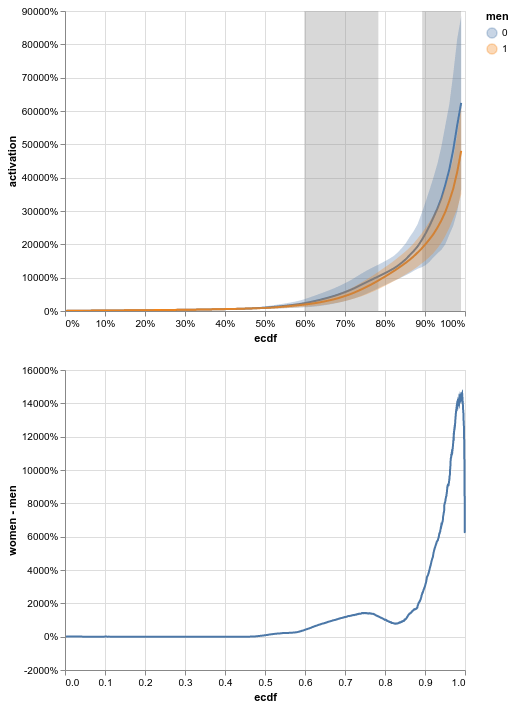

In [29]:
alt.Chart(clusters).mark_rect(opacity=0.3, color="grey").encode(
    alt.X("start"), alt.X2("end")
).transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N")
) & alt.Chart(
    act_melt.pivot_table(index="ecdf", columns="men", values="value", aggfunc="mean")
    .add_prefix("c")
    .eval("sub = c0 - c1")
    .reset_index()
).mark_line().encode(
    alt.X("ecdf"), alt.Y("sub", title="women - men", axis=alt.Axis(format="%"))
)

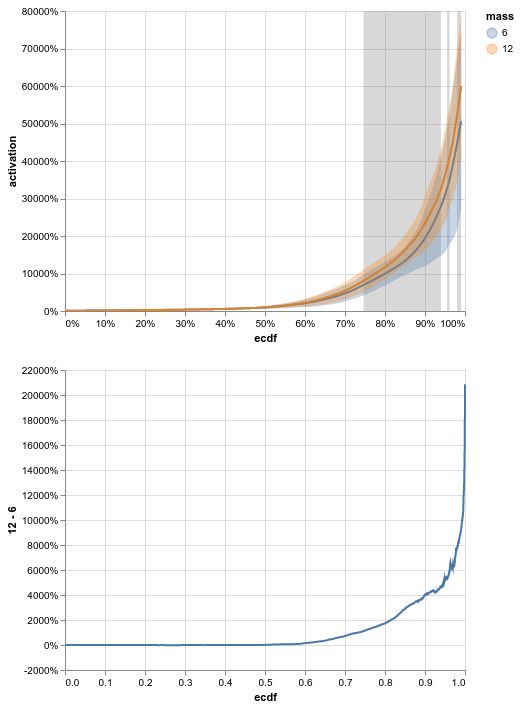

In [30]:
alt.Chart(clusters).mark_rect(opacity=0.3, color="grey").encode(
    alt.X("start"), alt.X2("end")
).transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
) & alt.Chart(
    act_melt.pivot_table(index="ecdf", columns="mass", values="value", aggfunc="mean")
    .add_prefix("c")
    .eval("sub = c12 - c6")
    .reset_index()
).mark_line().encode(
    alt.X("ecdf"), alt.Y("sub", title="12 - 6", axis=alt.Axis(format="%"))
)

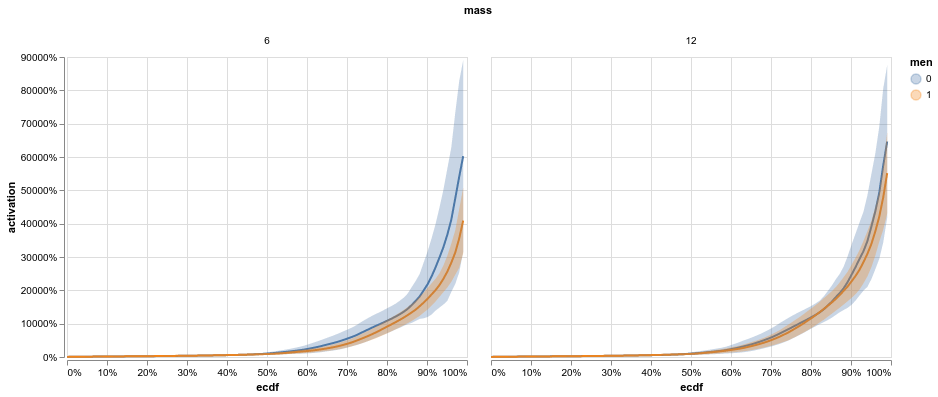

In [31]:
(mu + sigma).encode(alt.Color("men:N")).facet(column="mass")

## $\sum\sum\text{activations}$

In [32]:
sum_sum_act = (
    sum_act.groupby([i for i in id_vars if i != "index"])["value"].sum().reset_index()
)
sum_sum_act.head()

,filename,participant,men,height,mass,n_trial,value
0,AimQF12H2_1,aimq,0,2,12,1,150400.072240
1,AimQF12H2_2,aimq,0,2,12,2,141248.853327
2,AimQF12H2_3,aimq,0,2,12,3,134371.847651
3,AimQF6H2_1,aimq,0,2,6,1,143006.493601
4,AimQF6H2_2,aimq,0,2,6,2,210778.534066


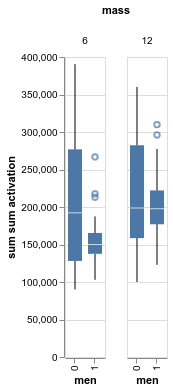

In [33]:
alt.Chart().mark_boxplot().encode(
    alt.X("men:N"), alt.Y("value", title="sum sum activation")
).facet(data=sum_sum_act, column=alt.Column("mass"))

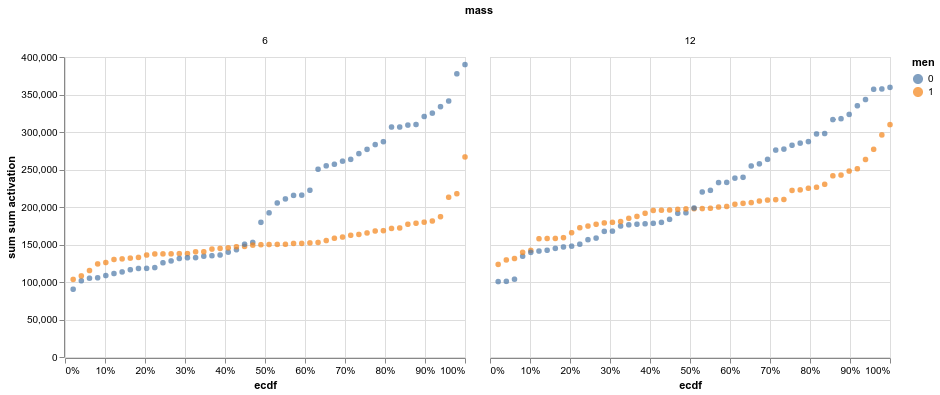

In [34]:
alt.Chart(
    sum_sum_act.assign(
        ecdf=lambda x: x.groupby(["men", "mass"])["value"].transform(
            lambda x: x.rank(method="first") / x.shape[0]
        )
    )
).mark_circle().encode(
    alt.X("ecdf", axis=alt.Axis(format="%")),
    alt.Y("value", title="sum sum activation"),
    alt.Color("men:N"),
    alt.Column("mass"),
)

<!--NAVIGATION-->
< [Analyses](02.00-analyses.ipynb) | [Contents](Index.ipynb) | [Joint reactions](02.02-joint-reactions.ipynb) >